In [119]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from collections import Counter
from datasets import load_dataset
from typing import List
from wordcloud import WordCloud

In [4]:
ds = load_dataset("Jsevisal/go_emotions_wheel")

In [5]:
df = pl.from_dicts(ds['train'][:])

In [7]:
df.head()

text,labels,id
str,list[i64],str
"""My favourite food is anything …",[5],"""eebbqej"""
"""Now if he does off himself, ev…",[5],"""ed00q6i"""
"""WHY THE FUCK IS BAYLESS ISOING""",[7],"""eezlygj"""
"""To make her feel threatened""",[2],"""ed7ypvh"""
"""Dirty Southern Wankers""",[7],"""ed0bdzj"""


In [9]:
df.describe()

statistic,text,labels,id
str,str,f64,str
"""count""","""43410""",43410.0,"""43410"""
"""null_count""","""0""",0.0,"""0"""
"""mean""",null,null,null
"""std""",null,null,null
"""min""",""" ""If you don't wear BROWN AND …",null,"""eczazk6"""
"""25%""",null,null,null
"""50%""",null,null,null
"""75%""",null,null,null
"""max""","""🦀🦀🦀🦀🦀🦀🦀🦀🦀I’m bad at this game🦀…",null,"""efhcreo"""


In [20]:
!python3 -m spacy download en_core_web_lg

     |████████████████████████████████| 400.7 MB 23 kB/s s eta 0:00:011                         | 67.9 MB 12.8 MB/s eta 0:00:27    |█████████▉                      | 123.0 MB 114.2 MB/s eta 0:00:03��███████▍                    | 143.1 MB 114.2 MB/s eta 0:00:03��██                  | 174.1 MB 91.4 MB/s eta 0:00:03�█████████▊                 | 184.5 MB 91.4 MB/s eta 0:00:03/s eta 0:00:03     |█████████████████               | 213.9 MB 91.4 MB/s eta 0:00:03��█▋            | 245.8 MB 91.4 MB/s eta 0:00:02��██            | 251.2 MB 91.4 MB/s eta 0:00:02 135.2 MB/s eta 0:00:01████▎         | 278.6 MB 135.2 MB/s eta 0:00:01��███████████████▋        | 296.2 MB 135.2 MB/s eta 0:00:01 319.5 MB 135.2 MB/s eta 0:00:01█████████████▏     | 328.3 MB 135.2 MB/s eta 0:00:01��███████▍     | 330.3 MB 135.2 MB/s eta 0:00:01��███████▌     | 332.3 MB 135.2 MB/s eta 0:00:01��████████████████████████▊   | 359.2 MB 16.7 MB/s eta 0:00:036.7 MB/s eta 0:00:02�█▎ | 379.7 MB 16.7 MB/s eta 0:00:02�█▋ | 382.8 MB 55.3

In [23]:
nlp = spacy.load('en_core_web_lg')

In [32]:
docs = list(nlp.pipe(df.select('text').to_series().to_list()))

In [33]:
token_lists = [[token.text for token in doc] for doc in docs]

In [34]:
token_counts = [len([t for t in doc if not t.is_punct and not t.is_space]) for doc in docs]

In [46]:
min_idx

32409

In [55]:
min_idx = token_counts.index(min(token_counts))
print(f"Renglón con MENOS tokens: {df.get_column('text')[min_idx]}")
print(f"Tamaño: {len(df.get_column('text')[min_idx])}")

Renglón con MENOS tokens: :((
Tamaño: 3


In [57]:
max_idx = token_counts.index(max(token_counts))
print(f"Renglón con MÁs tokens: {df.get_column('text')[max_idx]}")
print(f"Tamaño: {len(df.get_column('text')[max_idx])}")

Renglón con MÁs tokens: For your kindness to mobile users I give a platinum ⠀⠀⠀⠀⠀⣤⣶⣶⡶⠦⠴⠶⠶⠶⠶⡶⠶⠦⠶⠶⠶⠶⠶⠶⠶⣄⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⣿⣀⣀⣀⣀⠀⢀⣤⠄⠀⠀⣶⢤⣄⠀⠀⠀⣤⣤⣄⣿⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⠿⣿⣿⣿⣿⡷⠋⠁⠀⠀⠀⠙⠢⠙⠻⣿⡿⠿⠿⠫⠋⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⠀⢀⣤⠞⠉⠀⠀⠀⠀⣴⣶⣄⠀⠀⠀⢀⣕⠦⣀⠀⠀⠀⠀⠀⠀ ⠀⠀⠀⢀⣤⠾⠋⠁⠀⠀⠀⠀⢀⣼⣿⠟⢿⣆⠀⢠⡟⠉⠉⠊⠳⢤⣀⠀⠀⠀ ⠀⣠⡾⠛⠁⠀⠀⠀⠀⠀⢀⣀⣾⣿⠃⠀⡀⠹⣧⣘⠀⠀⠀⠀⠀⠀⠉⠳⢤⡀ ⠀⣿⡀⠀⠀⢠⣶⣶⣿⣿⣿⣿⡿⠁⠀⣼⠃⠀⢹⣿⣿⣿⣶⣶⣤⠀⠀⠀⢰⣷ ⠀⢿⣇⠀⠀⠈⠻⡟⠛⠋⠉⠉⠀⠀⡼⠃⠀⢠⣿⠋⠉⠉⠛⠛⠋⠀⢀⢀⣿⡏ ⠀⠘⣿⡄⠀⠀⠀⠈⠢⡀⠀⠀⠀⡼⠁⠀⢠⣿⠇⠀⠀⡀⠀⠀⠀⠀⡜⣼⡿⠀ ⠀⠀⢻⣷⠀⠀⠀⠀⠀⢸⡄⠀⢰⠃⠀⠀⣾⡟⠀⠀⠸⡇⠀⠀⠀⢰⢧⣿⠃⠀ ⠀⠀⠘⣿⣇⠀⠀⠀⠀⣿⠇⠀⠇⠀⠀⣼⠟⠀⠀⠀⠀⣇⠀⠀⢀⡟⣾⡟⠀⠀ ⠀⠀⠀⢹⣿⡄⠀⠀⠀⣿⠀⣀⣠⠴⠚⠛⠶⣤⣀⠀⠀⢻⠀⢀⡾⣹⣿⠃⠀⠀ ⠀⠀⠀⠀⢿⣷⠀⠀⠀⠙⠊⠁⠀⢠⡆⠀⠀⠀⠉⠛⠓⠋⠀⠸⢣⣿⠏⠀⠀⠀ ⠀⠀⠀⠀⠘⣿⣷⣦⣤⣤⣄⣀⣀⣿⣤⣤⣤⣤⣤⣄⣀⣀⣀⣀⣾⡟⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⢹⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠁⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⠀⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠃
Tamaño: 542


In [58]:
unigrams = [
    token.text.lower() for doc in docs for token in doc 
    if not token.is_stop and not token.is_punct and not token.is_space
]

unigram_counts = Counter(unigrams)

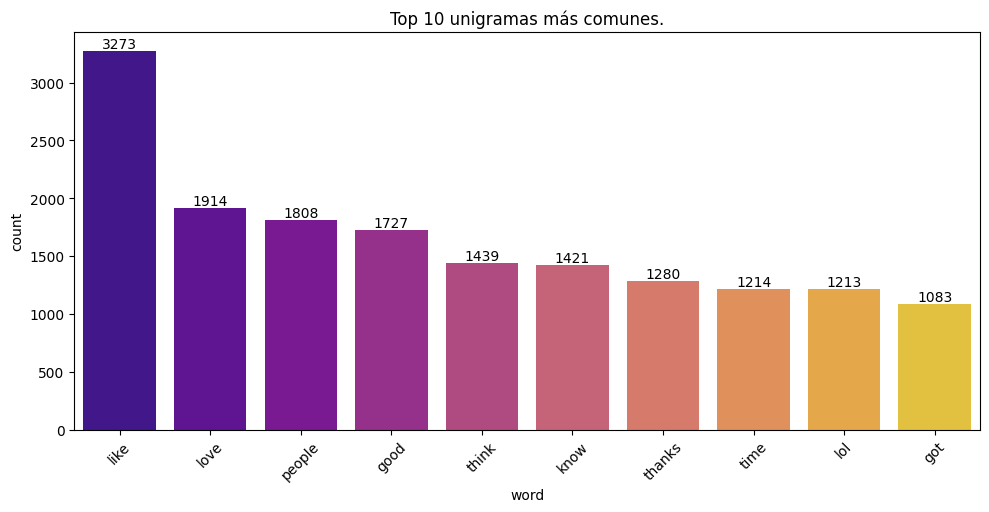

In [132]:
df_unigram_counts = pl.DataFrame(
    data = unigram_counts.most_common(10),
    schema = ['word', 'count'],
    orient = 'row'
)
plt.figure(figsize = (10, 5))
ax = sns.barplot(
    data = df_unigram_counts,
    x = 'word',
    y = 'count',
    hue = 'word',
    palette = 'plasma'
)
for container in ax.containers:
    ax.bar_label(container, 
                 fmt = '%.0f', 
                 label_type = 'edge', 
                 padding = 0)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.title('Top 10 unigramas más comunes.')
plt.savefig('img/unigramas_mas_comunes.png', dpi = 400)
plt.show()

In [14]:
def extract_multiword_terms(text: str) -> List[str]:
    text = re.sub(r'[^\w\s]', '', text.lower())
    doc = nlp(text)
    return [
        chunk.text for chunk in doc.noun_chunks
        if len(chunk.text.split()) >= 2
    ]

In [15]:
multiword_phrases =  df.select('text').to_series().to_list()

In [16]:
all_terms = []
for text in multiword_phrases:
    all_terms.extend(extract_multiword_terms(text))

In [85]:
term_counter = Counter(all_terms)

In [86]:
for term, freq in term_counter.most_common(10):
    print(f'{term} : {freq}')

i think : 70
thank you : 63
i hate : 49
i wish : 48
if you : 41
i have : 37
i had : 29
i cant : 25
i appreciate : 24
on the : 22


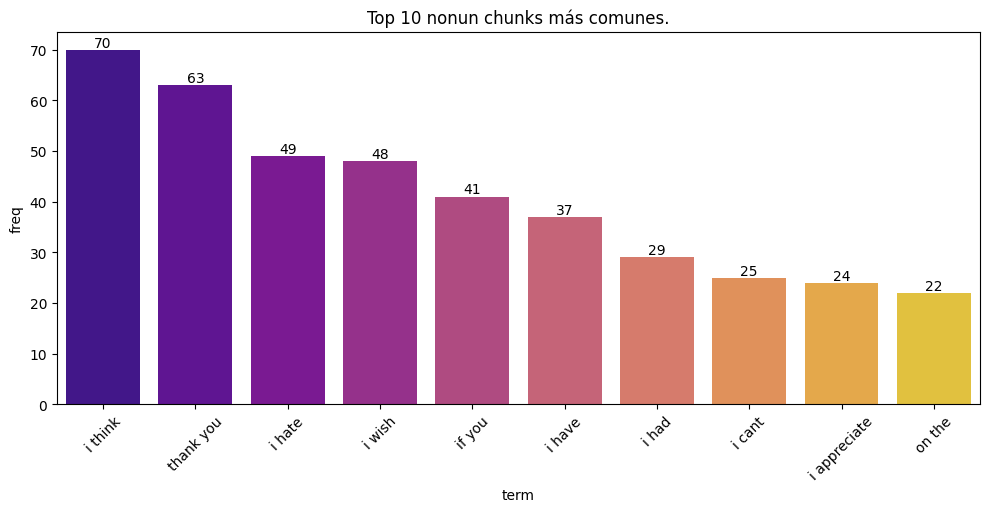

In [131]:
df_noun_chunks = pl.DataFrame(
    data = term_counter.most_common(10),
    schema = ['term', 'freq'],
    orient = 'row'
)
plt.figure(figsize = (10, 5))
ax = sns.barplot(
    data = df_noun_chunks,
    x = 'term',
    y = 'freq',
    hue = 'term',
    palette = 'plasma'
)
for container in ax.containers:
    ax.bar_label(
        container,
        fmt = '%.0f',
        label_type = 'edge',
        padding = 0
    )
plt.xticks(rotation = 45)
plt.tight_layout()
plt.title('Top 10 nonun chunks más comunes.')
plt.savefig('img/noun_chunks_mas_comunes.png', dpi = 400)
plt.show()

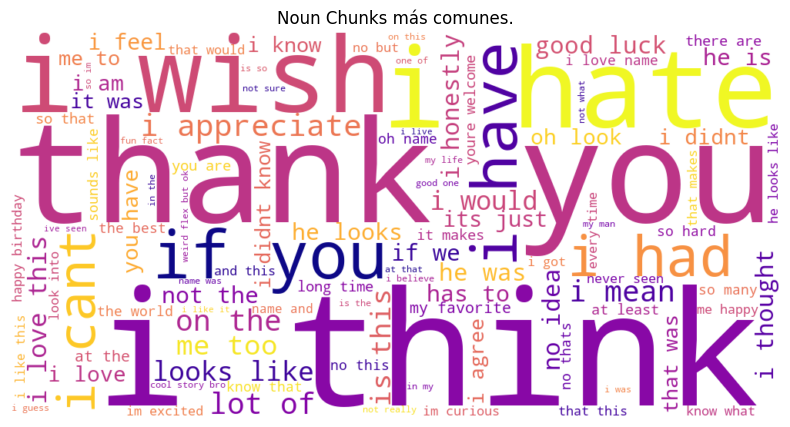

In [130]:
wordcloud = WordCloud(
    width = 1000,
    height = 500,
    max_words = 100,
    background_color = 'white',
    colormap = 'plasma'
).generate_from_frequencies(term_counter)
plt.figure(figsize = (10, 5))
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Noun Chunks más comunes.')
plt.savefig('img/word_cloud_noun_chunks.png', dpi = 400)
plt.show()